# Phase 1: Simple Garbage Classification with MobileNetV2

**Goal**: Build a working 12 category waste classifier using the Kaggle dataset

**Dataset**: 15,515 images across 12 categories:
- battery, biological, brown glass, cardboard, clothes, green glass
- metal, paper, plastic, shoes, trash, white glass

**Target**: >85% validation accuracy, deployable model

---

## 1. Environment Setup & Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: []


## 2. Dataset Loading & Exploration

In [3]:
# Dataset configuration
DATASET_PATH = "../data/Kaggle/garbage_classification"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Create datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_dataset.class_names
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset)}")

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.
Number of classes: 12
Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Training batches: 388
Validation batches: 97


## 3. Data Visualization

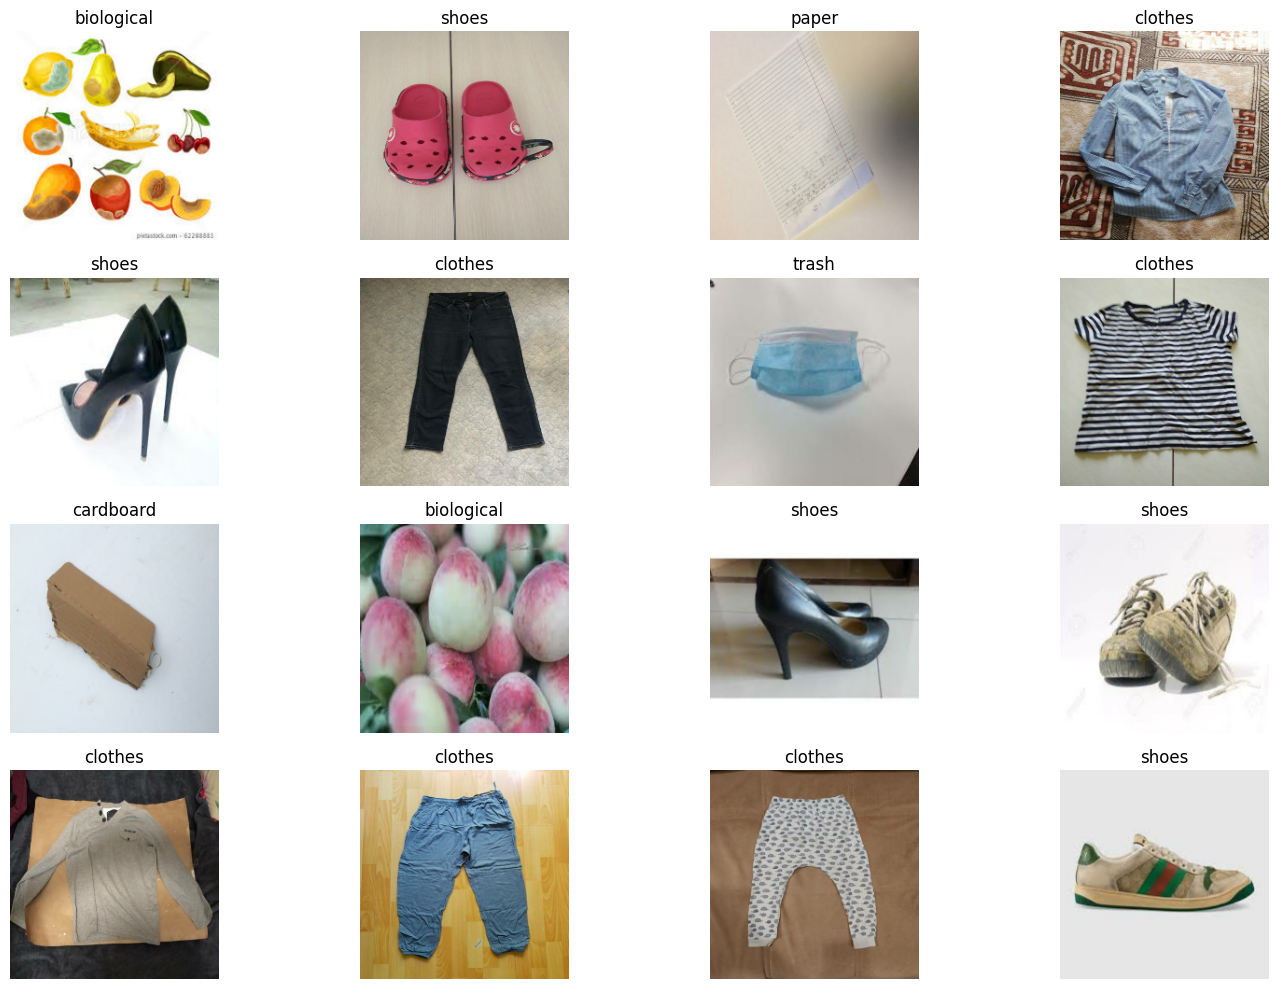

In [4]:
# Visualize sample images
plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(16, len(images))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[labels[i]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

## 4. Data Preprocessing & Augmentation

In [5]:
# Data augmentation for training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

# Preprocessing for MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)
    
    # Resize and rescale
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)
    
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    # MobileNetV2 preprocessing
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare_dataset(train_dataset, shuffle=True, augment=True)
val_ds = prepare_dataset(val_dataset)

print("Datasets prepared successfully!")

Datasets prepared successfully!


## 5. Model Architecture

In [6]:
def create_model():
    # Load pre trained MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Add custom classifier head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')
    ])
    
    return model

model = create_model()

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424,012 (9.25 MB)

 Trainable params: 165,772 (647.55 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

## 6. Training Setup

In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        '../models/phase1_best_model.keras',  # Using .keras format instead of .h5
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Training callbacks configured.")

Training callbacks configured.


## 7. Initial Training (Transfer Learning)

In [8]:
# Train with frozen base model first
print("Starting initial training with frozen base model...")

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

print("Initial training complete!")

Starting initial training with frozen base model...
Epoch 1/10
 36/388 ━━━━━━━━━━━━━━━━━━━━ 1:27 250ms/step - accuracy: 0.3239 - loss: 2.5313

KeyboardInterrupt: 

## 8. Fine-tuning (Optional)

In [ ]:
# Unfreeze top layers for fine-tuning
base_model = model.layers[0]
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Fine-tuning {len([l for l in base_model.layers if l.trainable])} layers...")

Fine-tuning 54 layers...


In [ ]:
# Continue training with fine-tuning
fine_tune_epochs = 5
total_epochs = len(history.history['loss']) + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.history['loss']),
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

print("Fine-tuning complete!")

Epoch 11/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8610 - loss: 0.4244
Epoch 11: val_accuracy improved from 0.94747 to 0.94779, saving model to ../models/phase1_best_model.h5

Epoch 11: val_accuracy improved from 0.94747 to 0.94779, saving model to ../models/phase1_best_model.h5


388/388 ━━━━━━━━━━━━━━━━━━━━ 164s 399ms/step - accuracy: 0.8610 - loss: 0.4244 - val_accuracy: 0.9478 - val_loss: 0.1665 - learning_rate: 1.0000e-05
Epoch 12/15
Epoch 12/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8938 - loss: 0.3287
Epoch 12: val_accuracy did not improve from 0.94779

Epoch 12: val_accuracy did not improve from 0.94779
388/388 ━━━━━━━━━━━━━━━━━━━━ 154s 387ms/step - accuracy: 0.8938 - loss: 0.3287 - val_accuracy: 0.9468 - val_loss: 0.1630 - learning_rate: 1.0000e-05
Epoch 13/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 154s 387ms/step - accuracy: 0.8938 - loss: 0.3287 - val_accuracy: 0.9468 - val_loss: 0.1630 - learning_rate: 1.0000e-05
Epoch 13/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9131 - loss: 0.2689
Epoch 13: val_accuracy did not improve from 0.94779

Epoch 13: val_accuracy did not improve from 0.94779
388/388 ━━━━━━━━━━━━━━━━━━━━ 155s 388ms/step - accuracy: 0.9131 - loss: 0.2690 - val_accuracy: 0.9471 - val_loss: 0.1622 - learning_rate: 1.0

388/388 ━━━━━━━━━━━━━━━━━━━━ 227s 576ms/step - accuracy: 0.9186 - loss: 0.2553 - val_accuracy: 0.9494 - val_loss: 0.1549 - learning_rate: 1.0000e-05
Epoch 15/15
Epoch 15/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9190 - loss: 0.2472 
Epoch 15: val_accuracy improved from 0.94940 to 0.95295, saving model to ../models/phase1_best_model.h5

Epoch 15: val_accuracy improved from 0.94940 to 0.95295, saving model to ../models/phase1_best_model.h5


388/388 ━━━━━━━━━━━━━━━━━━━━ 8236s 21s/step - accuracy: 0.9190 - loss: 0.2472 - val_accuracy: 0.9529 - val_loss: 0.1502 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 15.
Restoring model weights from the end of the best epoch: 15.
Fine-tuning complete!
Fine-tuning complete!


## 9. Results Visualization

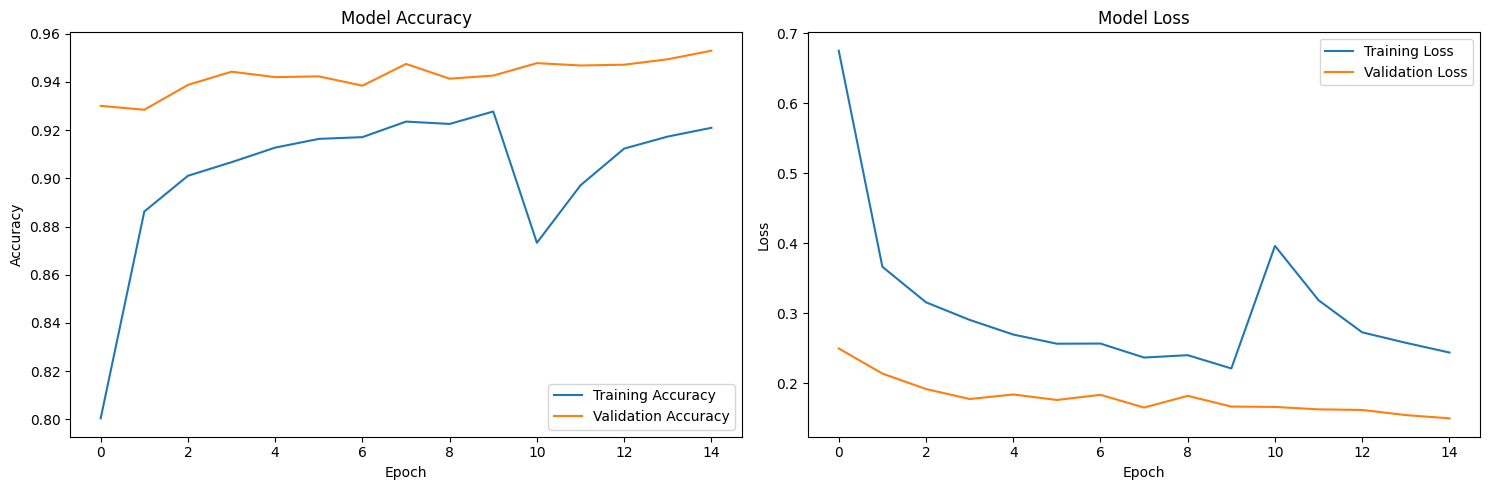

Final Training Accuracy: 0.9210
Final Validation Accuracy: 0.9529
Final Training Loss: 0.2441
Final Validation Loss: 0.1502


In [ ]:
# Plot training history
def plot_training_history(history, history_fine=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if history_fine:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"Final Training Accuracy: {acc[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"Final Training Loss: {loss[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss[-1]:.4f}")

try:
    plot_training_history(history, history_fine)
except:
    plot_training_history(history)

## 10. Model Evaluation & Testing

97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9548 - loss: 0.1522
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9548 - loss: 0.1522
Validation accuracy: 0.9529
Validation accuracy: 0.9529
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
Prediction shape: (32, 12)
Prediction shape: (32, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


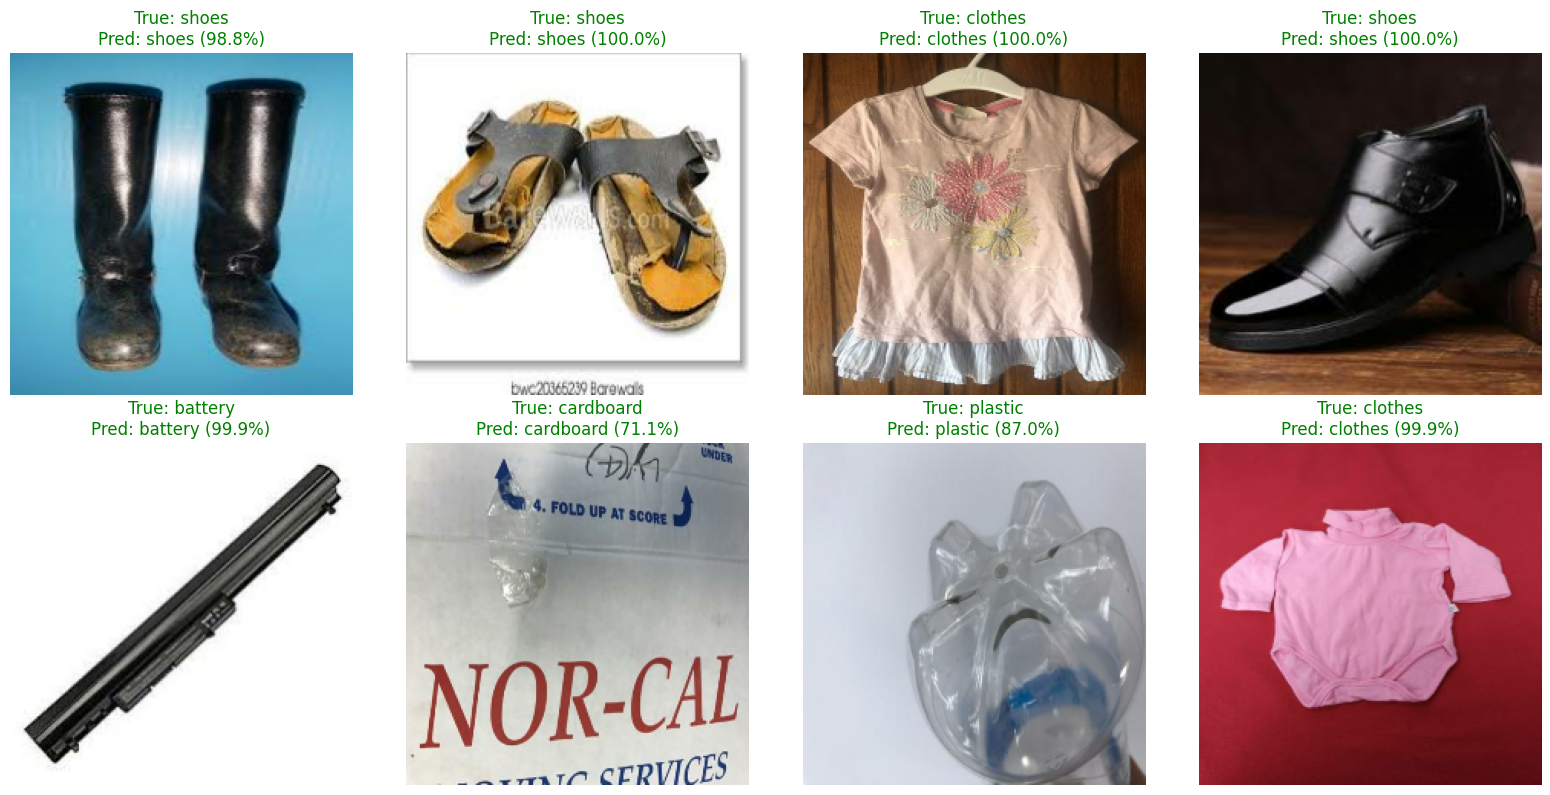

In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Make predictions on a batch
predictions = model.predict(val_ds.take(1))
print(f"Prediction shape: {predictions.shape}")

# Show prediction confidence
for images, labels in val_ds.take(1):
    pred_probs = model.predict(images[:8])
    pred_classes = np.argmax(pred_probs, axis=1)
    
    plt.figure(figsize=(16, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow((images[i].numpy() * 0.5 + 0.5))  
        
        true_label = class_names[labels[i]]
        pred_label = class_names[pred_classes[i]]
        confidence = np.max(pred_probs[i]) * 100
        
        color = 'green' if pred_classes[i] == labels[i] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    break

## 11. Save Final Model

In [18]:
# Save the final model in the newer .keras format (recommended)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"../models/phase1_final_model_{timestamp}.keras"

model.save(model_name)
print(f"Model saved as: {model_name}")

# Also save class names for later use
import json
with open('../models/class_names.json', 'w') as f:
    json.dump(class_names, f, indent=2)
print("Class names saved.")

# Model summary
print(f"\n=== PHASE 1 COMPLETE ===")
print(f"Final validation accuracy: {val_accuracy:.4f}")
print(f"Target achieved: {val_accuracy >= 0.85}")
print(f"Model ready for deployment: {model_name}")

Model saved as: ../models/phase1_final_model_20250830_202252.keras
Class names saved.

=== PHASE 1 COMPLETE ===
Final validation accuracy: 0.9507
Target achieved: True
Model ready for deployment: ../models/phase1_final_model_20250830_202252.keras
